In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image


In [2]:
#This is a test cell. Ideally this would be turned into a function
#Photo = cv2.imread('Output/Aaron_Eckhart/Aaron_Eckhart_0001.jpg', 0)
#Photo = cv2.medianBlur(Photo, 5)
#threshold3 = cv2.adaptiveThreshold(Photo, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                            cv2.THRESH_BINARY, 11, 2)


In [3]:
from PIL import Image


photosDirectory = []
CelebList = []
#First we load all of our files. 
def ReadDirect(path):
    directory = path
    for file2 in os.listdir(directory):
        path2 = directory + file2 
        CelebList.append(path2)
        pathForTemp = "Output/" + file2
        try:
            os.makedirs(pathForTemp)
        except:
            VOID = "do nothing :)"
            #This is just to skip the file already exists error
        for FilepathPhotos in os.listdir(path2):
            pathForPhoto = path2 + "/" + FilepathPhotos
            photosDirectory.append(pathForPhoto)
            #Dont run this code it opens every single image. (Good to see what images are being used)
            #image = Image.open(pathForPhoto) 
            #image.show()
#photosDirectory stores the file path for each image we are gonna use
#photosDirectory


In [7]:
path = 'SmallerDataSet(cleaned)/Adam_Sandler/'
ReadDirect(path)


In [19]:
#Now we make a function that finds the faces of each picture
FaceDat = cv2.CascadeClassifier("TrainingData/haarcascade_frontalface_default.xml")
EyeDat = cv2.CascadeClassifier("TrainingData/haarcascade_eye.xml")
def faceDetect(path, newDir):
    Photo = cv2.imread(path)
    
    #Blur to remove extra noise
    Photo2 = cv2.medianBlur(Photo, 3) 
    grysc = cv2.cvtColor(Photo2, cv2.COLOR_BGR2GRAY)
    faceDetected = FaceDat.detectMultiScale(grysc, 1.1, 4)
    eyeDetected = EyeDat.detectMultiScale(grysc, 1.3, 4)
    #This area ensures only one face is found per image
    facialPadding = 20
    #The way the algorithm works is it puts faces its less confident in first and most confident last so if multiple pictures are found we just pick the last one.
    #Should work most of the time
    faceFound = False
    if(len(faceDetected) != 1):
        
        #Gets eye coordinate
        count = 0
        eye1xCord = 0
        eye1ycord = 0
        eye2xCord = 0
        eye2ycord = 0
        for(ex, ey, ew, eh) in eyeDetected:
            #Ensures only two eyes are added to the image
            if(count < 2):
                #cv2.rectangle(Photo, ((ex), (ey)),((ex+ew), (ey+eh)), (0, 0, 255), 2)
                cv2.imwrite(newDir, Photo, [cv2.IMWRITE_JPEG_QUALITY, 100])
                if(count == 0):
                    eye1xCord = ex
                    eye1ycord = ey
                if(count == 1):
                    eye2xCord = ex
                    eye2ycord = ey
                count = count + 1
        
        numFaces = len(faceDetected)
        
        for i in range(numFaces):
            x1, y1, w1, h1 = faceDetected[i]
            xrang = x1 + w1
            yrang = y1 + h1
            if(eye1xCord, eye2xCord != 0):
                eye1Exist = True
            if(eye2xCord, eye2ycord != 0):
                eye2Exist = True
            #if eyes arent found then we shouldn't put the face because it could lead to errors in our mean faces.
            if(eye1Exist, eye2Exist == True):
                if(faceFound == False):
                    if(eye1xCord > x1):
                        if(eye1xCord < xrang):  
                            if(eye1ycord > y1):
                                if(eye1ycord < yrang):
                                    faceFound = True
                                    #For our paper we can use these rectangles to visualize what we are doing
                                    #cv2.rectangle(Photo, ((x1 - facialPadding), (y1 - facialPadding)),((x1+w1+facialPadding), (y1+h1+facialPadding)), (134, 255, 20), 2)
                                    faceModified = Photo[y1-facialPadding:y1 +facialPadding+h1, x1-facialPadding:x1+facialPadding+w1]
                                    photo = cv2.resize(faceModified, (250, 250))
                                    cv2.imwrite(newDir, photo, [cv2.IMWRITE_JPEG_QUALITY, 100])

    else:
        (x, y, w, h) = faceDetected[0]
        faceFound = True
        faceModified = Photo[y-facialPadding:y+facialPadding+h,x-facialPadding:x+facialPadding+w]
        photo1 = cv2.resize(faceModified, (250, 250))
        cv2.imwrite(newDir, photo1, [cv2.IMWRITE_JPEG_QUALITY, 100])
        
    if(faceFound == False):
        #Delete faces that couldn't be centered
        try:
            os.remove(newDir)
        except:
            alreadyRemoved = 0


In [20]:
#This recursively draws a rectangle around all of the faces we are reading.
newDir = []
for photos in photosDirectory:
    temp = photos.replace(path, "Output/")
    newDir.append(temp)
    #print(newDir)
    faceDetect(photos, temp)


In [21]:
from os.path import exists

#First remove empty directories
for Directory in newDir:
    fileExist = exists(Directory)
    if(fileExist == False):
        newDir.remove(Directory)


In [22]:
import math
def calcDis(a,b):
    xfirst = a[0]
    yfirst = a[1]
    
    xsecond = b[0]
    ysecond = b[1]
    return math.sqrt(((xsecond-xfirst)* (xsecond - xfirst)) + ((ysecond-yfirst) * (ysecond - yfirst)))

In [23]:
def FaceAllignRotate(PhotoDirectory):
    #Now we have to allign each face based on the angle of their eyes
    #for PhotoDirectory in Dir:
    try:
        EyeDat = cv2.CascadeClassifier("TrainingData/haarcascade_eye.xml")
        PhotoToAllign = cv2.imread(PhotoDirectory)
        PhotoToAllign = cv2.medianBlur(PhotoToAllign, 5)  
        gryscale = cv2.cvtColor(PhotoToAllign, cv2.COLOR_BGR2GRAY)
        eyesLoc = EyeDat.detectMultiScale(gryscale, 1.4, 4)
        loc = 0
        for(eyeXcord, eyeYcord, eyeWcord, eyeHcord) in eyesLoc:
            if(loc == 0):
                eye1 = (eyeXcord, eyeYcord, eyeWcord, eyeHcord)
            else:
                eye2 = (eyeXcord, eyeYcord, eyeWcord, eyeHcord)
            cv2.rectangle(PhotoToAllign, (eyeXcord, eyeYcord), (eyeXcord+eyeWcord, eyeYcord+eyeHcord),(0, 0, 255), 2)
            loc = loc + 1
    
        #Now we determine which eye corresponds with which side of the face
        if eye1[0] < eye2[0]:
            leftEye = eye1
            rightEye = eye2
        else:
            leftEye = eye2
            rightEye = eye1
        #Now we calculate the coordiantes of the eye
        leftEyeIris = (int(leftEye[0] + (leftEye[2]/2)), int(leftEye[1] + (leftEye[3]/2)))
        lefteyeXcord = leftEyeIris[0]
        lefteyeYcord = leftEyeIris[1]
        
        RightEyeIris = (int(rightEye[0] + (rightEye[2]/2)),int(rightEye[1] + (rightEye[3]/2)))
        righteyeXcord = RightEyeIris[0]
        righteyeYcord = RightEyeIris[1]
        cv2.circle(PhotoToAllign, leftEyeIris, 2, (0, 255, 0), 2)
        cv2.circle(PhotoToAllign, RightEyeIris, 2, (0, 255, 0), 2)
        cv2.line(PhotoToAllign, RightEyeIris, leftEyeIris, (255, 0, 0), 2)
        
        if leftEyeIris < RightEyeIris:
            point = (righteyeXcord, lefteyeYcord)
            direction = -1
        else:
            point = (lefteyeXcord, righteyeYcord)
            direction = 1
        cv2.circle(PhotoToAllign, point, 2, (255, 0, 0), 2)
        cv2.line(PhotoToAllign, RightEyeIris, leftEyeIris, (67, 67, 67), 2)
        cv2.line(PhotoToAllign, leftEyeIris, point, (67, 67, 67), 2)
        cv2.line(PhotoToAllign, RightEyeIris, point, (67, 67, 67), 2)

        firstCord = calcDis(leftEyeIris, point)
        secondCord = calcDis(RightEyeIris, leftEyeIris)
        thirdCord = calcDis(RightEyeIris, point)
    
        cos = (secondCord*secondCord + thirdCord*thirdCord - firstCord*firstCord) / (2*secondCord*thirdCord)
        #cos = cos
        
        angle = np.arccos(cos)
        angle = (angle * 180)
        angle = angle / math.pi
        
        if(direction == -1):
            angle = 90-angle
        #Now we generate the new image based on the angle

        imageToRototae = Image.open(PhotoDirectory)
        rotation = angle*direction
        #Prevents rotations that are too extreme
        if(rotation < 20):
            if(rotation > -20):
                rotated = imageToRototae.rotate(rotation)
                rotated.save(PhotoDirectory)
    except:
        donothing = 0
    


In [24]:
for direct in newDir:
    FaceAllignRotate(direct)


## PCA

First I am going to add some functions from the HW

In [25]:
#this is from Cogs 118B HW 4

def eigsort(V, eigvals):
# Sort the eigenvalues from largest to smallest. Store the sorted # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted

    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd) 
    Vsort = np.zeros((M, M)) 
    for i in range(M):
        Vsort[:,i] = V[:,index[i]] 
    return Vsort, Dsort

In [26]:
#this is from Cogs 118B HW 4

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

## Working with the photosDirectory from above

In [27]:
#turning the directory into an array to see shape

photosDirectory_1 = np.array(newDir)

#This is the numpy array of the directory of the path to the images
#There are 247 images
photosDirectory_1.shape


(78,)

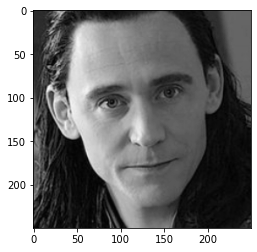

In [28]:
#This is the numerics for the first image
    #it is (250 pixels by 250 pixels)
    #We are going to turn it into a numpy array to work with it

photo_array = cv2.imread(photosDirectory_1[1], 0)
photo_array = np.array(photo_array)
#a = cv2.cvtColor(photo_array, cv2.COLOR_BGR2RGB)
#pix = np.array(a)
#plt.imshow(a)
plt.imshow(photo_array, 'gray')


In [29]:
#it is (250 pixels by 250 pixels)
photo_array.shape

#Reshape the matrix into a vector
#It is now a 62,500 vector
photo_array_reshaped = photo_array.reshape([62500, ])
photo_array_reshaped.shape

(62500,)

In [30]:
def viewimage_2(columnvector):
    #created fucntion to double check work
    plt.imshow(columnvector, cmap=plt.get_cmap('gray'))
 

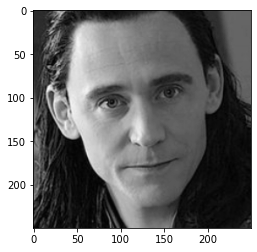

In [31]:
#this is to refer back to (to double check work)
viewimage_2(photo_array)

In [32]:
def viewvector(columnvector):
    #This transforms the numeric vector(62500,0) of the image back into a 250 by 250 image
    
    plt.imshow(columnvector.reshape([250, 250], order='C'), cmap=plt.get_cmap('gray'))



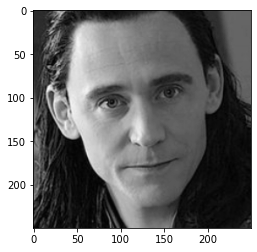

In [33]:
#This matches the image from above, so the function works properly
viewvector(photo_array_reshaped)

In [34]:
#turn this into a function later
#def photos_to_array (Directory_path_list): 



number_of_photos = len(newDir)
    #we want to iterate through all the photos
faces = []
    #as we iterate, we will want to append the outcomes
    


    
    
for i in range(number_of_photos):
    
    #for photo in photo directory
        #get the numeric interpretation
        #turn that into an array
        #Reshape the 250 pixels by 250 pixels into a vector
        #append the vector to the faces list
        
    
        
    photo_numbers = cv2.imread(photosDirectory_1[i], 0)
    photo_array = np.array(photo_numbers)
    photo_array_reshaped = photo_array.reshape([62500, ])
    
    faces.append(photo_array_reshaped)
    
#turn the faces list into an array
#transpose the array
faces = np.array(faces)
faces = faces.T



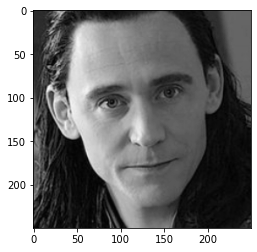

In [35]:
viewvector(faces[:,1])

## Now that we have the images in the form we want, we can start doing PCA

In [36]:
import numpy as np
#matrix operations- matlab is better for matrix, but this helps python
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
#contains some operations done in matlab
from sklearn.preprocessing import normalize
#huge library for ML- use normalize- convert vector to unit vector

%matplotlib inline

### Find the Mean Face

In [37]:
meanface = np.mean(faces, axis = 1)
    #sum along column direction, so axis = 1 (this is because each column is a unique image)
    #this is the same as (sum(faces, axis = 1)/ 48)
meanface = meanface[:, np.newaxis]

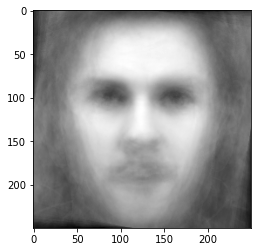

In [38]:
viewvector(meanface)

### Subtract the mean from all the data

In [40]:
A = faces - np.matlib.repmat(meanface, 1, len(newDir))

In [41]:
(A.T.dot(A)).shape
# use this because it is 247x247, as apposed to 62500x62500

(78, 78)

In [42]:
eigvals, Vold = np.linalg.eig(A.T.dot(A))

In [43]:
V, D = eigsort(Vold, eigvals)

In [44]:
U = A.dot(V)
U = normc(U)
c = U.T.dot(A[:,4])
U.shape

(62500, 78)

In [45]:
c = U.T.dot(A)

### Try recreating the second image with all 247 PC

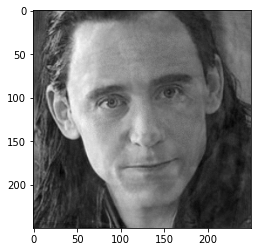

In [49]:
c = U.T.dot(faces[:, 1][:, np.newaxis] - meanface)
n = len(newDir)
reconstruction = U[:, :n].dot(c[:n, :]) + meanface
viewvector(reconstruction)

In [50]:
### Recreate image with less PC

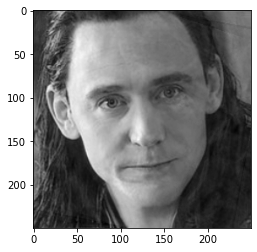

In [51]:
n = 50
reconstruction_2 = U[:, :n].dot(c[:n, :]) + meanface
viewvector(reconstruction_2)

In [ ]:
def PCA(newDir):
    
    photosDirectory_1 = np.array(newDir)
    
    
    number_of_photos = len(newDir)
    #we want to iterate through all the photos
    faces = []
    #as we iterate, we will want to append the outcomes
    


    
    
    for i in range(number_of_photos):
    
        #for photo in photo directory
        #get the numeric interpretation
        #turn that into an array
        #Reshape the 250 pixels by 250 pixels into a vector
        #append the vector to the faces list
        
    
        
        photo_numbers = cv2.imread(photosDirectory_1[i], 0)
        photo_array = np.array(photo_numbers)
        photo_array_reshaped = photo_array.reshape([62500, ])
    
        faces.append(photo_array_reshaped)
    
    #turn the faces list into an array
    #transpose the array
    faces = np.array(faces)
    faces = faces.T
    
    
    
    meanface = np.mean(faces, axis = 1)
    #sum along column direction, so axis = 1 (this is because each column is a unique image)
    #this is the same as (sum(faces, axis = 1)/ 48)
    meanface = meanface[:, np.newaxis]
    
    
    
    A = faces - np.matlib.repmat(meanface, 1, len(newDir))
    
    eigvals, Vold = np.linalg.eig(A.T.dot(A))
    V, D = eigsort(Vold, eigvals)
    
    U = A.dot(V)
    U = normc(U)
    c = U.T.dot(A)
    
    return meanface

In [ ]:
person = PCA(Direcotry of person)
